In [2]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#import tailer
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [3]:
rank_perc = [950, 990, 995]
#factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]

factors = ["CTCF","EBF1","SP1","PU1","RUNX3","NFYB","Nrf1","ELF1","NFKB","TCF3"]

factordata = {}
DIR="/storage/pandaman/project/singletons/AgentBind/"
for f in factors:
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "scores.tab"), sep="\t", skiprows=1,
                            names=["chrom","start","raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    print (f)

CTCF
EBF1
SP1
PU1
RUNX3
NFYB
Nrf1
ELF1
NFKB
TCF3


In [40]:
#trait = "WBC"; gwas = pd.read_csv("/storage/pandaman/project/GWAS/wbc_N172435_narrow_form.tsv.gz", sep="\t")
#trait = "RBC"; gwas = pd.read_csv("/storage/mgymrek/agent-bind/gwas/summstats/RBC_N172952_summ.tab", sep="\t")
#trait = "MCV"; gwas = pd.read_csv("/storage/mgymrek/agent-bind/gwas/summstats/MCV_N172433_summ.tab", sep="\t")
#trait = "Height"; gwas = pd.read_csv("/storage/mgymrek/agent-bind/gwas/summstats/HeightYengo_summ.tab", sep="\t")
trait = "IBD"; gwas = pd.read_csv("/storage/mgymrek/agent-bind/gwas/summstats/EUR.IBD_summ.tab", sep="\t")
gwas["CHR"] = gwas["CHR"].apply(lambda x: "chr"+str(x))
gwas["BP"] = gwas["BP"].apply(lambda x: x-1)
gwas = gwas.rename(columns={"CHR": "chrom", "BP": "start"})

In [41]:
gwd = {}
for f in factors:
    print(f)
    fd = factordata[f]
    fd["chrom"] = fd["chrom"].apply(str)
    merged_df = pd.merge(fd, gwas, on=["chrom","start"])
    merged_df = merged_df[((merged_df["REF"]).str.len() == 1) & ((merged_df["ALT"]).str.len() == 1)]
    merged_df = merged_df.sort_values("rank", ascending=False)
    merged_df = merged_df.drop_duplicates(subset=["chrom", "start"], keep='first')
    gwd[f] = merged_df

CTCF
EBF1
SP1
PU1
RUNX3
NFYB
Nrf1
ELF1
NFKB
TCF3


In [42]:
bins = [0, 0.00025, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]

In [43]:
gwd["SP1"].head()

,chrom,start,raw.score,snr.score,rank,core,factor,REF,ALT,MLOG10P,MA_FREQ
66325,chr3,101498076,0.000333,23.356206,1000.0,0,SP1,A,G,0.006564,0.06900
42568,chr3,133292101,0.000237,20.946120,1000.0,0,SP1,T,C,0.966174,0.01010
291,chr1,17380652,0.000102,14.370318,1000.0,0,SP1,A,C,0.066361,0.00627
51712,chr19,7633564,0.001314,40.433654,1000.0,0,SP1,C,G,0.361311,0.14200
99372,chr16,691812,0.000609,31.296192,1000.0,0,SP1,C,G,0.238674,0.00734


3538 622 3331
713 622 666
397 622 372


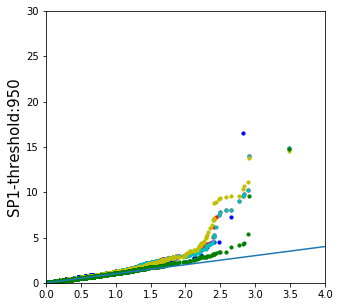

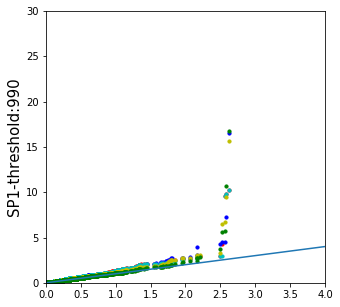

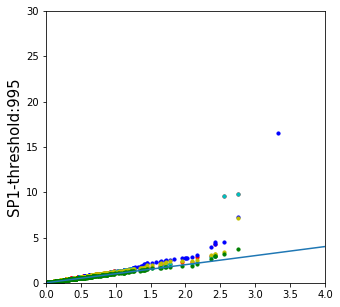

In [44]:
import random
from math import log10

for f in factors:
    if f != "SP1":
        continue
    for perc_index in range(len(rank_perc)):
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        core = gwd[f][gwd[f]["core"] == 1]
        noncore = high_scored_ab[high_scored_ab["core"] == 0]
        print (high_scored_ab.shape[0], core.shape[0], noncore.shape[0])
        # control - same MA_FREA distribution
        dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
        control_list = []
        control_list_all = []
        for bin_index in range(len(bins)-1):
            lower, upper = bins[bin_index], bins[bin_index + 1]
            n_samples = dist[bin_index]
            control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
            control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
        control = pd.concat(control_list)
        control_all = pd.concat(control_list_all)
                
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        s_core = core["MLOG10P"]
        s_noncore = noncore["MLOG10P"]
        s_ct = control["MLOG10P"]
        s_ct_all = control_all["MLOG10P"]

        
        s_random = [-log10(random.random()) for _ in range(max(high_scored_ab.shape[0], core.shape[0]))]
        s_random_ab = s_random[:high_scored_ab.shape[0]]
        s_random_core = s_random[:core.shape[0]]
        s_random_noncore = s_random[:noncore.shape[0]]
        
        y_points_ab = sorted(s_high_scored_ab.values.tolist())
        y_points_core = sorted(s_core.values.tolist())
        y_points_ct = sorted(s_ct.values.tolist())
        y_points_noncore = sorted(s_noncore.values.tolist())
        y_points_ct_all = sorted(s_ct_all.values.tolist())
        x_points_ab = sorted(s_random_ab)
        x_points_core = sorted(s_random_core)
        x_points_noncore = sorted(s_random_noncore)
        
        fig = plt.figure()
        fig.set_size_inches((5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(x_points_ab, y_points_ab, c="r", s=10)
        ax.scatter(x_points_core, y_points_core, c="b", s=10)
        ax.scatter(x_points_noncore, y_points_noncore, c="c", s=10)
        ax.scatter(x_points_ab, y_points_ct, c="y", s=10)
        ax.scatter(x_points_ab, y_points_ct_all, c="g", s=10)
        ax.set_ylabel("%s-threshold:%d" %(f, rank_perc[perc_index]), size=15)
        ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
        ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

In [45]:
results = gwd["SP1"][gwd["SP1"]["rank"] >= rank_perc[0]]
results = results.sort_values("MLOG10P", ascending=False)
#with open("/storage/pandaman/project/GWAS/high_scored.csv", 'w') as ofile:
#    ofile.write(results.to_csv(index=False))

In [46]:
results

,chrom,start,raw.score,snr.score,rank,core,factor,REF,ALT,MLOG10P,MA_FREQ
15621,chr17,37912376,0.000249,9.412739,981.0,0,SP1,T,C,14.869700,0.4950
44350,chr6,32806552,0.000119,5.075731,963.0,0,SP1,A,G,13.989300,0.0125
3722,chr3,49761570,0.000082,18.527810,991.0,0,SP1,A,G,10.290000,0.4470
68678,chr9,139305023,0.000043,14.861786,997.0,0,SP1,A,G,9.759200,0.2650
114781,chr9,139377498,0.000057,25.171382,998.0,0,SP1,A,G,9.598080,0.2900
...,...,...,...,...,...,...,...,...,...,...,...
113159,chr9,130965538,0.000019,3.460992,960.0,0,SP1,A,G,0.000608,0.0211
19832,chr20,61640655,0.000057,7.548926,987.0,0,SP1,A,G,0.000521,0.0165
54339,chr1,198590765,0.000262,12.527613,993.0,0,SP1,T,G,0.000435,0.0332
71914,chr19,34625544,0.000060,9.399262,998.0,0,SP1,C,G,0.000391,0.3420


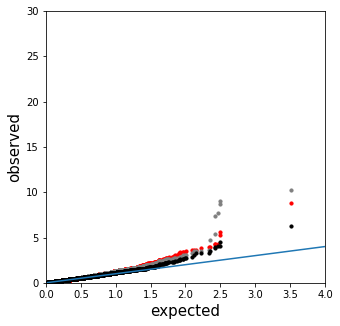

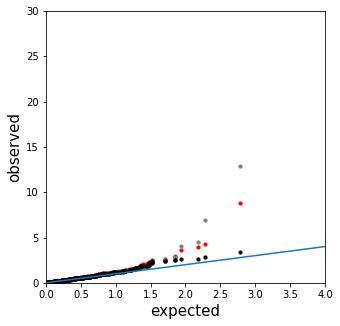

In [47]:
for f in factors:
    if f != "Nrf1":
        continue
    for perc_index in [0,1]:
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]

        # control - same MA_FREA distribution
        dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
        control_list = []
        control_list_all = []
        for bin_index in range(len(bins)-1):
            lower, upper = bins[bin_index], bins[bin_index + 1]
            n_samples = dist[bin_index]
            control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
            control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
        control = pd.concat(control_list)
        control_all = pd.concat(control_list_all)
        
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        s_ct = control["MLOG10P"]
        s_ct_all = control_all["MLOG10P"]

        s_random = [-log10(random.random()) for _ in range(high_scored_ab.shape[0])]
        
        y_points_ab = sorted(s_high_scored_ab.values.tolist())
        y_points_ct = sorted(s_ct.values.tolist())
        y_points_ct_all = sorted(s_ct_all.values.tolist())
        x_points = sorted(s_random)
        
        fig = plt.figure()
        fig.set_size_inches((5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(x_points, y_points_ab, c="r", s=10)
        ax.scatter(x_points, y_points_ct, c="grey", s=10)
        ax.scatter(x_points, y_points_ct_all, c="k", s=10)
        ax.set_xlabel("expected", size=15)
        ax.set_ylabel("observed", size=15)
        ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
        ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        fig.savefig("AgentBindGWAS-%s-%s-%s.pdf"%(f, trait, rank_perc[perc_index]))

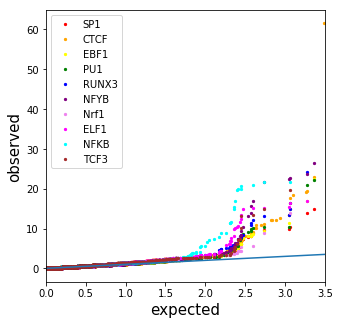

In [48]:
factors_to_plot = factors #["IRF4", "PU1", "ZEB1", "Znf143"]
#f2c = {"IRF4":"b", "PU1":'r', "ZEB1":"c", "Znf143":"k"}
#["CTCF","EBF1","SP1","PU1","RUNX3","NFYB","NRF1","ELF1","NFKB","TCF3"]
f2c = {
    "SP1": "red",
    "CTCF": "orange",
    "EBF1": "yellow",
    "PU1": "green",
    "RUNX3": "blue",
    "NFYB": "purple",
    "Nrf1": "violet",
    "ELF1": "magenta",
    "NFKB": "cyan",
    "TCF3": "brown"
}

for perc_index in [0]:
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("expected", size=15)
    ax.set_ylabel("observed", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 3.5), (0, 30))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    
    s_random = [-log10(random.random()) for _ in range(int(10e6))]
    for f in f2c.keys():
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        y_points_ab = sorted(s_high_scored_ab.values.tolist())        
        x_points = sorted(s_random[:high_scored_ab.shape[0]])     
        ax.scatter(x_points, y_points_ab,  s=5, c=f2c[f], label=f)
    ax.legend(loc="upper left")
    fig.savefig("AgentBind-MultiFactor-%s.pdf"%trait)
    fig.savefig("AgentBind-MultiFactor-%s.png"%trait)
